In [1]:
from torchsift import detect, visualize_keypoints, draw_match_lines, concat, ransac, listwise_match, ikp_qkp, draw_transfrom_points, sample_descriptors
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import torchvision.transforms as T
from PIL import Image
import torch
from tqdm.auto import tqdm

In [2]:
resize = T.Resize(256)
transforms = T.Compose([T.Resize(256), T.RandomRotation(30), T.RandomAffine(0, translate=(0.2, 0.2)), T.RandomPerspective(distortion_scale=0.5), T.PILToTensor()])

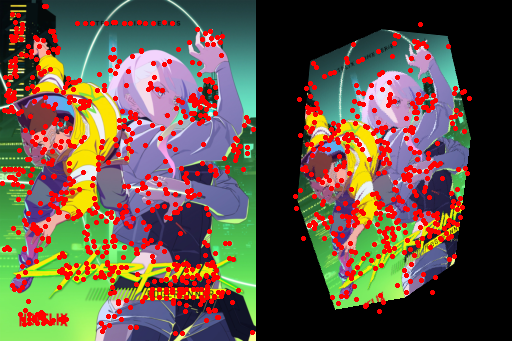

In [3]:
example_image_path = 'example.jpg'
image = Image.open(example_image_path).convert('RGB')

index_image = resize(image)
index_image = pil_to_tensor(index_image)
query_image = transforms(image)

idx_kps, idx_descs = detect(index_image)
index_kps_image = visualize_keypoints(index_image, idx_kps.unsqueeze(0))

query_kps, query_descs = detect(query_image)
query_kps_image = visualize_keypoints(query_image, query_kps.unsqueeze(0))

side_by_side = concat(index_kps_image, query_kps_image, dim=1)
side_by_side

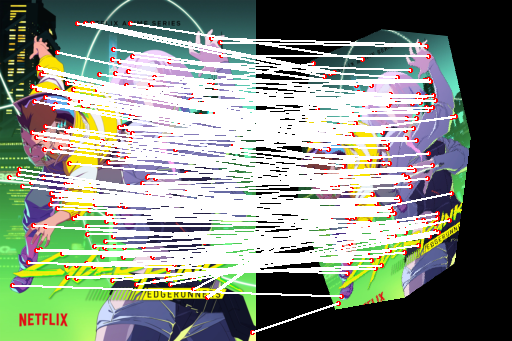

In [4]:
idx_idesc_qdesc = listwise_match(idx_descs.unsqueeze(0), query_descs.unsqueeze(0))
idx_ikp, idx_qkp = ikp_qkp(idx_kps.unsqueeze(0), query_kps.unsqueeze(0), idx_idesc_qdesc)
lines_without_ransac = draw_match_lines(index_image, query_image, idx_ikp.squeeze(0), idx_qkp.squeeze(0))
lines_without_ransac

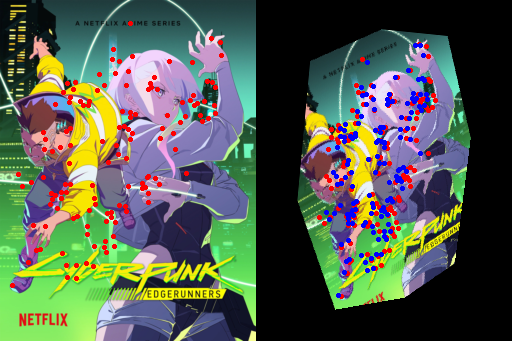

In [5]:
H, selected_X, selected_Y = ransac(idx_ikp, idx_qkp)
ransac_index_kps_image = visualize_keypoints(index_image, selected_X.unsqueeze(0))
ransac_query_kps_image = visualize_keypoints(query_image, selected_Y.unsqueeze(0))

ransac_kps_side_by_side = draw_transfrom_points(index_image, query_image, H, selected_X, selected_Y)
ransac_kps_side_by_side

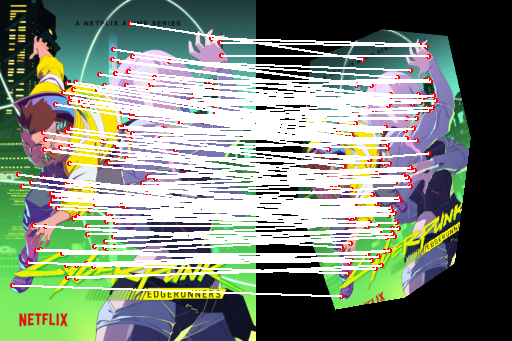

In [6]:
ransac_lines_side_by_size = draw_match_lines(index_image, query_image, selected_X, selected_Y)
ransac_lines_side_by_size

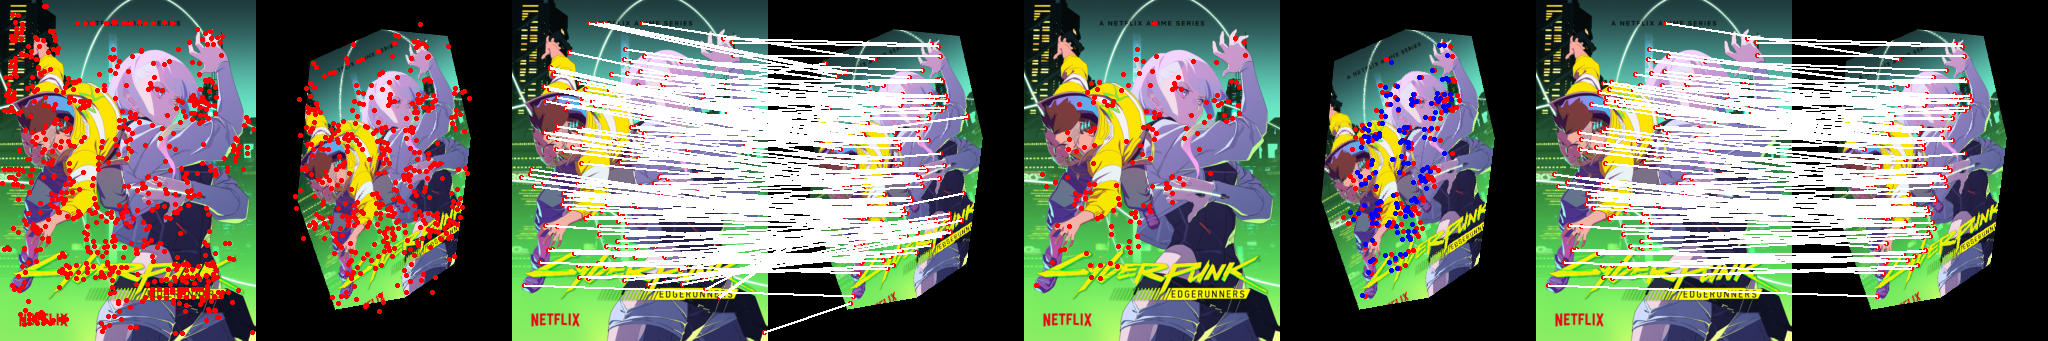

In [7]:
outcome = concat(side_by_side, lines_without_ransac)
outcome = concat(outcome, ransac_kps_side_by_side)
outcome = concat(outcome, ransac_lines_side_by_size)
outcome

In [8]:
N = 10000
index_images = torch.randint(0, 255, (N, 3, 64, 256), dtype=torch.uint8, device='cuda').cpu()
query_images = torch.randint(0, 255, (N, 3, 64, 256), dtype=torch.uint8, device='cuda').cpu()

chunk_size = 8
n_chunks = N // chunk_size

In [9]:
skipped = 0
for i in (pbar := tqdm(range(n_chunks))):
    index = index_images[i * chunk_size: (i + 1) * chunk_size]
    query = query_images[i * chunk_size: (i + 1) * chunk_size]
    
    idx_kps = []
    idx_descs = []
    query_kps = []
    query_descs = []
    
    for j in range(chunk_size):
        kps, descs = detect(index[j])
        kps, descs = sample_descriptors(kps, descs)
        idx_kps.append(kps)
        idx_descs.append(descs)
        
        kps, descs = detect(query[j])
        kps, descs = sample_descriptors(kps, descs)
        query_kps.append(kps)
        query_descs.append(descs)
    
    idx_kps = torch.stack(idx_kps)
    idx_descs = torch.stack(idx_descs)
    query_kps = torch.stack(query_kps)
    query_descs = torch.stack(query_descs)
    
    idx_idesc_qdesc = listwise_match(idx_descs, query_descs)
    if idx_idesc_qdesc.numel() == 0:
        skipped += 1
        continue
    idx_ikp, idx_qkp = ikp_qkp(idx_kps, query_kps, idx_idesc_qdesc)
    H, selected_X, selected_Y = ransac(idx_ikp, idx_qkp)
    pbar.set_postfix({'skipped': skipped / (i + 1)})
    
    
    


  0%|          | 0/1250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
N = 10000
idx_kps = torch.randint(0, 255, (N, 256, 2), device='cuda').cpu()
query_kps = torch.randint(0, 255, (N, 256, 2), device='cuda').cpu()
idx_idesc_qdesc = torch.randint(0, 255, (N, 256, 256), device='cuda').cpu()
chunk_size = 32
n_chunks = N // chunk_size

In [13]:
for i in (pbar := tqdm(range(n_chunks))):
    idx2query = idx_idesc_qdesc[i * chunk_size: (i + 1) * chunk_size]
    idx_ikp, idx_qkp = ikp_qkp(idx_kps, query_kps, idx2query)
    H, selected_X, selected_Y = ransac(idx_ikp, idx_qkp)
    print(selected_X)

  0%|          | 0/312 [00:00<?, ?it/s]

tensor([[112.,  19.],
        [ 54., 164.],
        [239., 214.],
        ...,
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]], device='cuda:0')
tensor([[223., 120.],
        [  3., 249.],
        [216., 201.],
        ...,
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]], device='cuda:0')
tensor([[102.,  11.],
        [234., 236.],
        [166., 162.],
        ...,
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]], device='cuda:0')
tensor([[ 14., 187.],
        [109., 135.],
        [110., 111.],
        ...,
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]], device='cuda:0')
tensor([[108.,  44.],
        [ 50.,  47.],
        [  1., 221.],
        ...,
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]], device='cuda:0')
tensor([[158., 123.],
        [220., 207.],
        [ 87., 109.],
        ...,
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]], device='cuda:0')
tensor([[149.,  66.],


KeyboardInterrupt: 